# Bayesian Networks

**Colaborators:** Andrej Betík (456604), Robin Knaur (409844), Jiří Novotný (409963)

## 1. Introduction

### We have chosen these three methods
 - Bayesian Generalized Linear Model
 - Bayesian Additive Regression Trees
 - method 3
 
 ### And we have these three datasets
 - Bank dataset
 - German Credit Data
 - dataset 3
 

## 2. Exploratory Analysis

### Bank dataset
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

#### Attribute Information:

##### Input variables:
###### bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
###### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
###### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
###### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

###### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')


### German Credit Data
The original dataset contains 1000 entries with 20 categorial/symbolic attributes. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.
I have ignored som columns, because either they are not important or their descriptions are obscure.

#### Attribute Information:
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
###### Output variable (desired target)
10. Risk (Value target - Good or Bad Risk)

### Visualization

'data.frame':	1000 obs. of  10 variables:
 $ Age             : int  67 22 49 45 53 35 53 35 61 28 ...
 $ Sex             : Factor w/ 2 levels "female","male": 2 1 2 2 2 2 2 2 2 2 ...
 $ Job             : int  2 2 1 2 2 1 2 3 1 3 ...
 $ Housing         : Factor w/ 3 levels "free","own","rent": 2 2 2 1 1 1 2 3 2 2 ...
 $ Saving.accounts : Factor w/ 4 levels "little","moderate",..: NA 1 1 1 1 NA 3 1 4 1 ...
 $ Checking.account: Factor w/ 3 levels "little","moderate",..: 1 2 NA 1 1 NA NA 2 NA 2 ...
 $ Credit.amount   : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ Duration        : int  6 48 12 42 24 36 24 36 12 30 ...
 $ Purpose         : Factor w/ 8 levels "business","car",..: 6 6 4 5 2 4 5 2 6 2 ...
 $ Risk            : Factor w/ 2 levels "bad","good": 2 1 2 2 1 2 2 2 2 1 ...


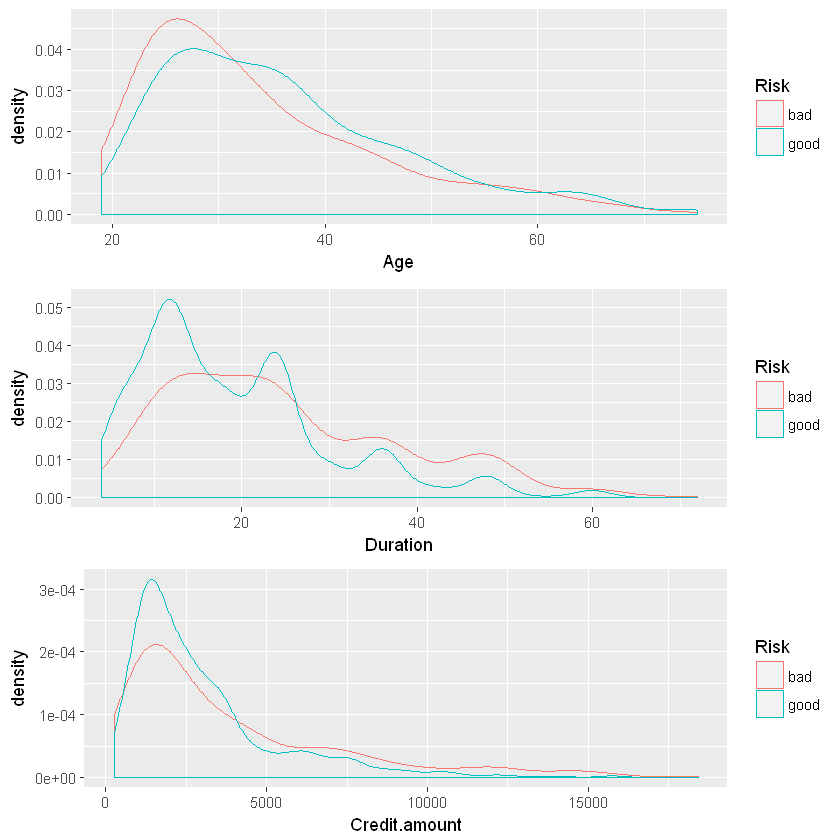

In [35]:
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(gridExtra)))
german_credit <- read.csv("datasets/german_credit.csv")
str(german_credit)
# People at very young age seem to have worse credit worthiness
p1 <- ggplot(german_credit, aes(x=Age, color=Risk)) + geom_density()
# Surprisingly there's not really a trend of "Longer duration better credit worthiness"
p2 <- ggplot(german_credit, aes(x=Duration, color=Risk)) + geom_density()
# A trend of "Higher credit amount, better credit worthiness"
p3 <- ggplot(german_credit, aes(x=Credit.amount, color=Risk)) + geom_density()
grid.arrange(p1, p2, p3)

## 3. Preprocessing

### Bank dataset

This dataset could be used without any preprocessing, but it still be usefull to do some.

First remove the duration column, becase it represents length of a phonecall which couldn't be known before phonecall itself and strongly correlate with output variable.

Since it's a telemarketing, majority of people refused an offer, so the distribution of classes is unbalanced I decided to use oversampling to deal with this issue. If I wouldn't use it sensitivity would be very low.
```
#load datasets
bank_train <- read.csv("bank-additional.csv", sep=";")
bank_test <- read.csv("bank-additional-full.csv", sep=";")

#remove duration column
bank_train_without_duration <- subset(bank_train, select = -c(duration))
bank_test_without_duration <- subset(bank_test, select = -c(duration))

# oversampling
library(splitstackshape)

yes_rows = subset(bank_train, y == 'yes')
multiplied_yes_rows = expandRows(yes_rows, 8, count.is.col = FALSE, drop = FALSE)
oversampled_bank_train = rbind(bank_train, multiplied_yes_rows)


```

### Bank dataset
There are missing values.

In [38]:
sum(is.na(german_credit))
# But all of them are in attributes Saving.accounts and Checking.accounts which are categorical values
sum(is.na(german_credit$Checking.account)) + sum(is.na(german_credit$Saving.accounts))
head(german_credit$Saving.accounts, n = 15)
head(german_credit$Checking.account, n = 15)

[1] 577

[1] 577

[1] <NA>       little     little     little     little     <NA>      
 [7] quite rich little     rich       little     little     little    
[13] little     little     little    
Levels: little moderate quite rich rich

[1] little   moderate <NA>     little   little   <NA>     <NA>     moderate
 [9] <NA>     moderate moderate little   moderate little   little  
Levels: little moderate rich

In [39]:
# To get rid of missing values I replace <NA> samples with a new level "Unknown"
levels(german_credit$Saving.accounts) = c(levels(german_credit$Saving.accounts), "Unknown")
german_credit$Saving.accounts[which(is.na(german_credit$Saving.accounts))] = "Unknown"
levels(german_credit$Checking.account) = c(levels(german_credit$Checking.account), "Unknown")
german_credit$Checking.account[which(is.na(german_credit$Checking.account))] = "Unknown"
head(german_credit$Saving.accounts)
head(german_credit$Checking.account)
sum(is.na(german_credit))

[1] Unknown little  little  little  little  Unknown
Levels: little moderate quite rich rich Unknown

[1] little   moderate Unknown  little   little   Unknown 
Levels: little moderate rich Unknown

[1] 0

## 4. Learning Algorithms

### Bayesian Generalized Linear Model
```
model <- train(y ~ ., data = oversampled_bank_train, method = 'bayesglm')

prediction <- predict(model, newdata = bank_test)
confusionMatrix(prediction, bank_test$y, positive="yes")

```

### Bayesian Additive Regression Trees

In [40]:
# Setting computing parameters. 4 GB RAM for Java heap and number of computing cores set to 4.
suppressPackageStartupMessages(suppressWarnings(options(java.parameters = "-Xmx4g")))
suppressPackageStartupMessages(suppressWarnings(library("bartMachine")))
suppressPackageStartupMessages(suppressWarnings(set_bart_machine_num_cores(4)))

bartMachine now using 4 cores.


In [41]:
# Creating a data partition to train
set.seed(123)
trainIndex <- createDataPartition(german_credit$Risk, .75, list=FALSE, times = 1)
trControl <- trainControl(method = "cv",  number=5, verboseIter=FALSE)
bartmachine_fit <- suppressWarnings(train(Risk ~ ., 
                                          data = german_credit[trainIndex,], 
                                          method ="bartMachine",
                                          tuneLength = 5, 
                                          trControl = trControl,
                                          metric = 'Accuracy'))

bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 22 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for classification ...
evaluating in sample data...done
bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 22 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for classification ...
evaluating in sample data...done
bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 22 total features...
bartMachine sigsq estimated...
bartMachine training data final

In [42]:
bartMachine_predict <- predict(bartmachine_fit, german_credit[-trainIndex,])
confusionMatrix(bartMachine_predict, german_credit[-trainIndex,]$Risk)

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad   25   11
      good  50  164
                                          
               Accuracy : 0.756           
                 95% CI : (0.6979, 0.8079)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.02945         
                                          
                  Kappa : 0.3177          
 Mcnemar's Test P-Value : 1.142e-06       
                                          
            Sensitivity : 0.3333          
            Specificity : 0.9371          
         Pos Pred Value : 0.6944          
         Neg Pred Value : 0.7664          
             Prevalence : 0.3000          
         Detection Rate : 0.1000          
   Detection Prevalence : 0.1440          
      Balanced Accuracy : 0.6352          
                                          
       'Positive' Class : bad             
                                          

In [43]:
# Bayesian Generalized Linear Model
suppressPackageStartupMessages(suppressWarnings(library(arm)))
glm_fit <- suppressWarnings(train(Risk ~ ., 
                                  data = german_credit[trainIndex,], 
                                  method ="bayesglm",
                                  tuneLength = 5, 
                                  trControl = trControl,
                                  preProc = c('center', 'scale'),
                                  metric = 'Accuracy'))

In [44]:
bayesglm_test_pred <- predict(glm_fit, german_credit[-trainIndex,])
confusionMatrix(bayesglm_test_pred, german_credit[-trainIndex,]$Risk)

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad   23   12
      good  52  163
                                          
               Accuracy : 0.744           
                 95% CI : (0.6852, 0.7969)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.07209         
                                          
                  Kappa : 0.2809          
 Mcnemar's Test P-Value : 1.088e-06       
                                          
            Sensitivity : 0.3067          
            Specificity : 0.9314          
         Pos Pred Value : 0.6571          
         Neg Pred Value : 0.7581          
             Prevalence : 0.3000          
         Detection Rate : 0.0920          
   Detection Prevalence : 0.1400          
      Balanced Accuracy : 0.6190          
                                          
       'Positive' Class : bad             
                                          

## 5. Evaluation

## 6. Conclusion

## 7. References

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing